### Introduction ###

Welcome to my review of recent video games sales! I'll be using this data to identify patterns for the upcoming 2017 sales campaign. I will identify what platforms are succeding and on the rise, what region is best to do business in and what genre of games will be the most profitable.

In [76]:
# import all nesecarry packages
import pandas as pd
import streamlit as st
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FixedLocator
import numpy as np
from collections import Counter
import re
import math
import scipy.stats as stats
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, Dropdown
from IPython.display import display

In [2]:
# read in the data
games = pd.read_csv(r'c:\Users\Darth Piggyus\Github-Projects\Intergated-project\games.csv')

In [3]:
# get an overview of the data
print(games.head())
games.info()
games.describe()

                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Missing values in 'Name', Year_of_Release', 'Genre', 'Critic_score', User_Score', and 'Rating'; 'Year_of_Release' should be int type; 'User_Score' should be float type; Year of Release ranges from 1980 to 2016

In [4]:
# make all column names lowercase
games.columns = games.columns.str.lower()

In [5]:
# display the rows with missing values in the 'name' column
print(games[games['name'].isnull()])

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  


In [6]:
# fill the missing values in the 'name' column
games['name'] = games['name'].fillna('Unknown')

# check to makes sure there are no empty values
print(games[games['name'].isnull()])

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []


I'm using 'Unknown' here for the names because there's really no way of know what games these are specificlly. They also shouldn't be relavent to our data since we're looking at 2016.

In [7]:
# Update the year_of_release for the game at index 15957
games.at[15957, 'year_of_release'] = 2010

In [8]:
print(games.loc[15957])

name               Strongest Tokyo University Shogi DS
platform                                            DS
year_of_release                                 2010.0
genre                                           Action
na_sales                                           0.0
eu_sales                                           0.0
jp_sales                                          0.02
other_sales                                        0.0
critic_score                                       NaN
user_score                                         NaN
rating                                             NaN
Name: 15957, dtype: object


I noticed later in the code that this game had a listed release data much earlier than it's console so I looked up the date online and replaced it

In [9]:
# display the rows with missing values in the 'year_of_release' column
print(games[games['year_of_release'].isnull()])

# Check for missing values in the 'year_of_release' column
print(f"Number of missing values in the 'year_of_release' column: {games['year_of_release'].isnull().sum()}")



                                    name platform  year_of_release  \
183                      Madden NFL 2004      PS2              NaN   
377                     FIFA Soccer 2004      PS2              NaN   
456           LEGO Batman: The Videogame      Wii              NaN   
475           wwe Smackdown vs. Raw 2006      PS2              NaN   
609                       Space Invaders     2600              NaN   
...                                  ...      ...              ...   
16373  PDC World Championship Darts 2008      PSP              NaN   
16405                      Freaky Flyers       GC              NaN   
16448                          Inversion       PC              NaN   
16458        Hakuouki: Shinsengumi Kitan      PS3              NaN   
16522                       Virtua Quest       GC              NaN   

              genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
183          Sports      4.26      0.26      0.01         0.71          94.0   

First I can check the name of each game for a year and use that to fill for those. The rest I'll fill by grouping by platform and find the median year

In [10]:
# Function to extract year from game name
def extract_year_from_name(name):
    year_pattern = r'\b(\d{4})\b'
    match = re.search(year_pattern, name)
    if match:
        return int(match.group(1))
    else:
        return None

# Apply the function to the 'name' column and update the 'year_of_release' column only for rows with missing values
games.loc[games['year_of_release'].isnull(), 'year_of_release'] = games.loc[games['year_of_release'].isnull(), 'name'].apply(extract_year_from_name)

# Check for missing values in the 'year_of_release' column
print(f"Number of missing values in the 'year_of_release' column: {games['year_of_release'].isnull().sum()}")

Number of missing values in the 'year_of_release' column: 252


In [11]:
# Group the data by 'platform' and calculate the median 'year_of_release' for each group
platform_medians = games.groupby('platform')['year_of_release'].median().round().to_dict()

# Fill the missing values in the 'year_of_release' column using the platform medians
games.loc[games['year_of_release'].isnull(), 'year_of_release'] = games.loc[games['year_of_release'].isnull(), 'platform'].map(platform_medians)

# Check for missing values in the 'year_of_release' column
print(f"Number of missing values in the 'year_of_release' column: {games['year_of_release'].isnull().sum()}")

Number of missing values in the 'year_of_release' column: 0


In [12]:
# convert 'year_of_release' to int
games['year_of_release'] = games['year_of_release'].astype(int)

A few of the games were able to tell me when they came out from the name but for the others i decided to group them by what platform they came out on and finding the median year for games that came out on that platform. Finally I converted it to int type because the variable only deals in whole numbers.

In [13]:
# display the rows with missing values in the 'genre' column
print(games[games['genre'].isnull()])

          name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    Unknown      GEN             1993   NaN      1.78      0.53      0.00   
14244  Unknown      GEN             1993   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  


In [14]:
# Filter the data for the year 1993
games_1993 = games[games['year_of_release'] == 1993]

# Find the most common genre
genre_counts = Counter(games_1993['genre'])
most_common_genre = genre_counts.most_common(1)[0][0]

# Fill the missing values in the 'genre' column with the most common genre
games['genre'] = games['genre'].fillna(most_common_genre)

# display the rows with missing values in the 'genre' column
print(games[games['genre'].isnull()])

Empty DataFrame
Columns: [name, platform, year_of_release, genre, na_sales, eu_sales, jp_sales, other_sales, critic_score, user_score, rating]
Index: []


Here I decided to find the most common genre for the year these games came out and apply it to these.

In [15]:
# check for duplicate rows
print(games.duplicated().sum())

0


In [16]:
# Add a new column 'total_sales' that calculates the sum of the individual sales columns
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [17]:
# Group the data by year and count the number of games
games_by_year = games.groupby('year_of_release').size().reset_index(name='count')

# Display the results
games_by_year

,year_of_release,count
0,1980,9
1,1981,46
2,1982,53
3,1983,17
4,1984,14
5,1985,13
6,1986,21
7,1987,16
8,1988,15
9,1989,17


I'll likely use data from 2012 to 2016 since the number of released games is about the same for those years and they're the most recent.

In [18]:
# Filter the data for the years 2012-2016
games_2012_2016 = games[(games['year_of_release'] >= 2012) & (games['year_of_release'] <= 2016)]

# Group the data by platform and sum the sales
platform_sales_2012_2016 = games_2012_2016.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

# Print the top 5 platforms by total sales
platform_sales_2012_2016.head(5)

platform
PS4     314.14
PS3     288.79
X360    236.54
3DS     195.80
XOne    159.32
Name: total_sales, dtype: float64

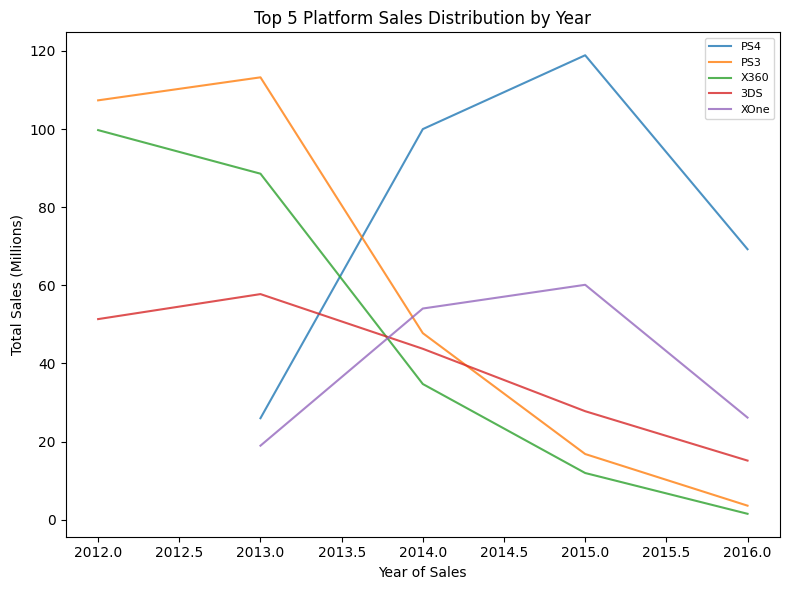

In [19]:
# Group the data by platform and year, and sum the total_sales column
platform_sales_by_year = games_2012_2016.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

# Pivot the table to have years as columns and platforms as rows
platform_sales_pivot = platform_sales_by_year.pivot(index='platform', columns='year_of_release', values='total_sales')

# Get top 5 platforms
top_5_platforms = platform_sales_pivot.sum(axis=1).nlargest(5).index

# Plot the distribution
fig1, ax = plt.subplots(figsize=(8, 6))

for platform in top_5_platforms:
    ax.plot(list(platform_sales_pivot.columns), platform_sales_pivot.loc[platform], marker='', alpha=0.8, label=platform)

ax.set_title('Top 5 Platform Sales Distribution by Year')
ax.set_xlabel('Year of Sales')
ax.set_ylabel('Total Sales (Millions)')
ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

Looking at the top 5 platforms from recent years PS3, X360 and 3DS seem to be at the end of their lifetime.

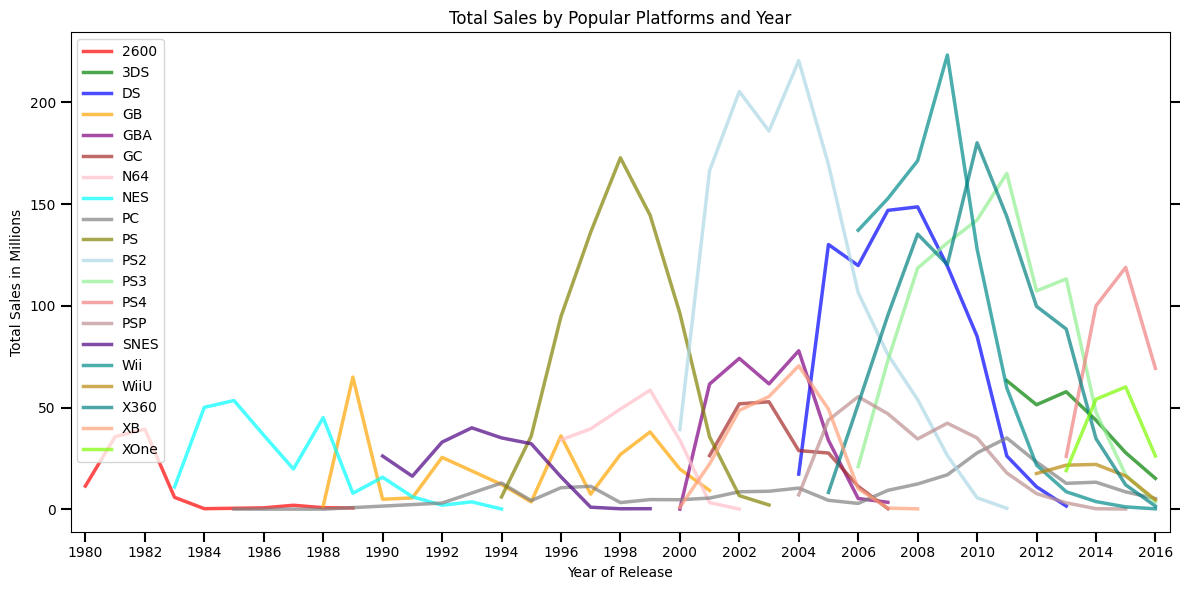

In [20]:
# Group the data by platform and year, and sum the total_sales column
platform_sales_by_year = games.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

# Find platforms with total sales greater than 20 million in at least one year
popular_platforms = platform_sales_by_year[platform_sales_by_year['total_sales'] > 20]['platform'].unique()

# Create a figure with one subplot
fig2, ax = plt.subplots(figsize=(12, 6))

# Define a list of colors for the popular platforms
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'cyan', 'gray', 'olive']
colors += ['lightblue', 'lightgreen', 'lightcoral', 'rosybrown', 'indigo', 'darkcyan', 'darkgoldenrod', 'teal', 'lightsalmon', 'lawngreen', 'orchid', 'palegreen', 'darkorchid', 'paleturquoise', 'crimson', 'darkred']

# Plot the sales distribution for each popular platform
for i, platform in enumerate(popular_platforms):
    platform_data = platform_sales_by_year[platform_sales_by_year['platform'] == platform]
    ax.plot(platform_data['year_of_release'], platform_data['total_sales'], color=colors[i % len(colors)], alpha=0.7, label=platform, linewidth=2.5)

ax.set_title('Total Sales by Popular Platforms and Year')
ax.set_xlabel('Year of Release')
ax.set_ylabel('Total Sales in Millions')
ax.set_xlim([1979.5, 2016.5])
ax.legend()

# Add x-ticks for each year
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:d}'.format(int(x))))

# Set the x-ticks' vertical alignment to the bottom
ax.xaxis.set_tick_params(which='both', direction='out', bottom=True, top=False, width=1.5, length=7)

# Remove the y-ticks' vertical alignment
ax.yaxis.set_tick_params(which='both', direction='out', right=True, left=True, width=1.5, length=7)

plt.tight_layout()
plt.show()

In [21]:
# Find the start and end years for each popular platform
platform_year_range = platform_sales_by_year.groupby('platform')['year_of_release'].agg(['min', 'max']).reset_index()

# Calculate the difference between the end year and start year for each platform
platform_year_range['year_range'] = platform_year_range['max'].sub(platform_year_range['min'])

# Find the average length in years that the popular platforms are in business
average_year_range = platform_year_range['year_range'].mean()

print(f'The average length in years that the popular platforms are in business: {average_year_range:.1f} years')

The average length in years that the popular platforms are in business: 7.0 years


Now I'll filter the data to just be working with games from 2012 to 2016

In [22]:
# Print the resulting DataFrame
games_2012_2016

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


In [23]:
games_2012_2016.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2896 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2896 non-null   object 
 1   platform         2896 non-null   object 
 2   year_of_release  2896 non-null   int32  
 3   genre            2896 non-null   object 
 4   na_sales         2896 non-null   float64
 5   eu_sales         2896 non-null   float64
 6   jp_sales         2896 non-null   float64
 7   other_sales      2896 non-null   float64
 8   critic_score     1316 non-null   float64
 9   user_score       1670 non-null   object 
 10  rating           1618 non-null   object 
 11  total_sales      2896 non-null   float64
dtypes: float64(6), int32(1), object(5)
memory usage: 282.8+ KB


I need to fill the Null values in the critic score and user score still. I'll start by grouping by platform and genre and using the average critic score from each group.

In [24]:
# Group the data by 'platform' and 'genre', then calculate the mean 'critic_score' for each group
mean_critic_scores = games_2012_2016.groupby(['platform', 'genre'])['critic_score'].mean().round(1).to_dict()

# Fill the missing values in the 'critic_score' column using the platform-genre mean critic scores
games_2012_2016.loc[games_2012_2016['critic_score'].isnull(), 'critic_score'] = games_2012_2016.loc[games_2012_2016['critic_score'].isnull(), ['platform', 'genre']].apply(lambda x: mean_critic_scores.get(tuple(x), games_2012_2016['critic_score'].mean()), axis=1)

# Check for missing values in the 'critic_score' column
print(f"Number of missing values in the 'critic_score' column: {games_2012_2016['critic_score'].isnull().sum()}")

# Get the rows with missing values in the 'critic_score' column
missing_critic_scores = games_2012_2016[games_2012_2016['critic_score'].isnull()]

# Print the missing rows
missing_critic_scores

Number of missing values in the 'critic_score' column: 213


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
766,Skylanders SWAP Force,Wii,2013,Platform,1.21,0.75,0.00,0.19,NaN,6.6,E10+,2.15
2139,Dragon Quest X,Wii,2012,Role-Playing,0.00,0.00,0.96,0.00,NaN,NaN,NaN,0.96
2963,LEGO Batman 2: DC Super Heroes,DS,2012,Action,0.39,0.24,0.00,0.06,NaN,8,E10+,0.69
3055,Puzzler Brain Games,Wii,2012,Puzzle,0.00,0.00,0.66,0.00,NaN,NaN,NaN,0.66
3087,Rocksmith 2014,PC,2013,Misc,0.36,0.24,0.00,0.06,NaN,NaN,NaN,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...
16637,Onigokko! Portable,PSP,2013,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16646,Time Travelers,PSP,2012,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16659,Hyakki Yagyou Kaidan Romance,PSP,2012,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16682,Grisaia no Kajitsu: La Fruit de la Grisaia,PSP,2013,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


For the remaining null values I'll fill them with the average score from the genre overall.

In [25]:
# Group the data by 'genre' and calculate the mean 'critic_score' for each genre
genre_mean_critic_scores = games_2012_2016.groupby('genre')['critic_score'].mean().round(1).to_dict()

# Fill the remaining missing values in the 'critic_score' column with the genre average
games_2012_2016.loc[games_2012_2016['critic_score'].isnull(), 'critic_score'] = games_2012_2016.loc[games_2012_2016['critic_score'].isnull(), 'genre'].map(genre_mean_critic_scores)

# Check for remaining missing values in the 'critic_score' column
print(f"Number of missing values in the 'critic_score' column: {games_2012_2016['critic_score'].isnull().sum()}")

# Get the rows with missing values in the 'critic_score' column
missing_critic_scores = games_2012_2016[games_2012_2016['critic_score'].isnull()]

# Print the missing rows
missing_critic_scores

Number of missing values in the 'critic_score' column: 0


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales


For user scores with a tbd value I will give them 5.0 since thats the average of potential scores. Then I'll convert to float so that i can easily work with the numbers. 

In [26]:
# Replace 'tbd' values in the 'user_score' column with 5.0
games_2012_2016.loc[:, 'user_score'] = games_2012_2016['user_score'].replace('tbd', 5.0)
 
# Convert the 'user_score' column to float and round to the nearest 0.1
games_2012_2016['user_score'] = games_2012_2016['user_score'].astype(str).str.replace(',', '').str.replace('%', '').astype(float).round(1) # Converting the column to string first to handle any non-numeric characters and removing those non-numeric characters using string methods

# Group the data by 'genre' and 'platform', calculate the mean 'user_score' for each group
group_mean_user_scores = games_2012_2016.groupby(['genre', 'platform'])['user_score'].mean().round(1).to_dict()

# Fill the remaining missing values in the 'user_score' column with the group average
games_2012_2016.loc[games_2012_2016['user_score'].isnull(), 'user_score'] = games_2012_2016.loc[games_2012_2016['user_score'].isnull(), ['genre', 'platform']].apply(lambda x: group_mean_user_scores[(x['genre'], x['platform'])], axis=1)

# Check for remaining missing values in the 'user_score' column
print(f"Number of missing values in the 'user_score' column: {games_2012_2016['user_score'].isnull().sum()}")

Number of missing values in the 'user_score' column: 86


C:\Users\Darth Piggyus\AppData\Local\Temp\ipykernel_2944\3721322006.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_2012_2016['user_score'] = games_2012_2016['user_score'].astype(str).str.replace(',', '').str.replace('%', '').astype(float).round(1) # Converting the column to string first to handle any non-numeric characters and removing those non-numeric characters using string methods


For the remaining null values I'll fill them with the average score from the genres overall.

In [27]:
# Group the data by 'genre' and calculate the mean 'user_score' for each genre
genre_mean_user_scores = games_2012_2016.groupby('genre')['user_score'].mean().round(1).to_dict()

# Fill the remaining missing values in the 'user_score' column with the genre average
games_2012_2016.loc[games_2012_2016['user_score'].isnull(), 'user_score'] = games_2012_2016.loc[games_2012_2016['user_score'].isnull(), 'genre'].map(genre_mean_user_scores)

# Check for remaining missing values in the 'user_score' column
print(f"Number of missing values in the 'user_score' column: {games_2012_2016['user_score'].isnull().sum()}")

Number of missing values in the 'user_score' column: 0


In [28]:
games_2012_2016.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2896 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2896 non-null   object 
 1   platform         2896 non-null   object 
 2   year_of_release  2896 non-null   int32  
 3   genre            2896 non-null   object 
 4   na_sales         2896 non-null   float64
 5   eu_sales         2896 non-null   float64
 6   jp_sales         2896 non-null   float64
 7   other_sales      2896 non-null   float64
 8   critic_score     2896 non-null   float64
 9   user_score       2896 non-null   float64
 10  rating           1618 non-null   object 
 11  total_sales      2896 non-null   float64
dtypes: float64(7), int32(1), object(4)
memory usage: 282.8+ KB


Finally I'll fill the null values in the ratings column

In [29]:
games_2012_2016['rating'].value_counts(dropna=False)

rating
NaN     1278
M        499
T        414
E        397
E10+     308
Name: count, dtype: int64

I'll group these by Genre and Platform again but this time find the mode of the ratings for each

In [30]:
# Drop null values from data frame before finding the modes
most_common_ratings = games_2012_2016.dropna(subset=['rating'])

# Group the DataFrame by 'genre' and 'platform', and find the most common 'rating' for each group
most_common_ratings = most_common_ratings.groupby(['genre', 'platform'])['rating'].apply(lambda x: x.mode()[0])

# Create a dictionary to map the group keys to the most common ratings
rating_map = most_common_ratings.to_dict()

# Fill the null values in the 'rating' column with the most common rating for each group
games_2012_2016.loc[:, 'rating'] = games_2012_2016.apply(lambda row: rating_map.get((row['genre'], row['platform']), row['rating']), axis=1)

games_2012_2016['rating'].value_counts(dropna=False)

rating
M       1049
T        650
E        634
E10+     479
NaN       84
Name: count, dtype: int64

The last few I'll assign the most common rating found for the genre

In [31]:
# Find the most common rating for each genre
most_common_ratings = games_2012_2016.groupby('genre')['rating'].apply(lambda x: x.mode().iloc[0])

# Create a dictionary to map the genres to the most common ratings
rating_map = most_common_ratings.to_dict()

# Fill the null values in the 'rating' column with the most common rating for each genre
games_2012_2016.loc[:, 'rating'] = games_2012_2016['rating'].fillna(games_2012_2016['genre'].map(rating_map))

games_2012_2016['rating'].value_counts(dropna=False)

rating
M       1101
T        660
E        641
E10+     494
Name: count, dtype: int64

In [32]:
games_2012_2016.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2896 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2896 non-null   object 
 1   platform         2896 non-null   object 
 2   year_of_release  2896 non-null   int32  
 3   genre            2896 non-null   object 
 4   na_sales         2896 non-null   float64
 5   eu_sales         2896 non-null   float64
 6   jp_sales         2896 non-null   float64
 7   other_sales      2896 non-null   float64
 8   critic_score     2896 non-null   float64
 9   user_score       2896 non-null   float64
 10  rating           2896 non-null   object 
 11  total_sales      2896 non-null   float64
dtypes: float64(7), int32(1), object(4)
memory usage: 282.8+ KB


In [33]:
# Reset the index and drop the old index column
games_2012_2016 = games_2012_2016.reset_index(drop=True)

In [34]:
games_2012_2016

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,75.2,6.6,M,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,72.6,7.6,T,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
2891,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,71.4,7.8,M,0.01
2892,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,80.7,8.2,T,0.01
2893,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,72.4,6.7,M,0.01
2894,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,71.4,7.8,M,0.01


From now on i'll only be working with the games_2012_2016 data, its been cleaned and refined and should be relavent to my task

In [35]:
# Group the data by platform and sum the total_sales column
platform_sales_sum = games_2012_2016.groupby('platform')['total_sales'].sum().reset_index()

# Sort the result by total_sales in descending order
platform_sales_sum_sorted = platform_sales_sum.sort_values(by='total_sales', ascending=False)

platform_sales_sum_sorted


,platform,total_sales
4,PS4,314.14
3,PS3,288.79
9,X360,236.54
0,3DS,195.80
10,XOne,159.32
8,WiiU,82.19
2,PC,63.00
6,PSV,49.44
7,Wii,35.37
1,DS,12.55


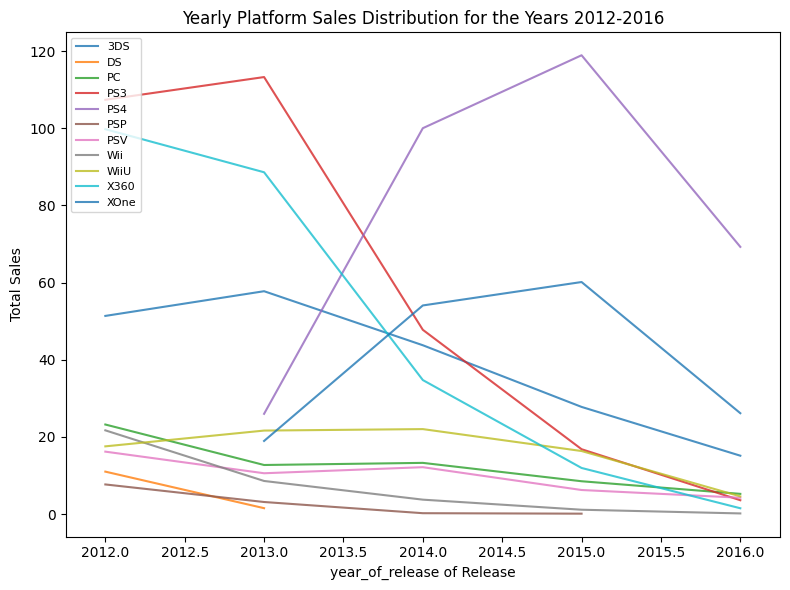

In [36]:
# Group the data by platform and year, and sum the total_sales column
platform_sales_by_year = games_2012_2016.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

# Pivot the table to have years as columns and platforms as rows
platform_sales_pivot = platform_sales_by_year.pivot(index='platform', columns='year_of_release', values='total_sales')

# Plot the distribution
fig3, ax = plt.subplots(figsize=(8, 6))

for platform, sales_data in platform_sales_pivot.iterrows():
    ax.plot(list(sales_data.index), sales_data.values, marker='', alpha=0.8, label=platform)

ax.set_title('Yearly Platform Sales Distribution for the Years 2012-2016')
ax.set_xlabel('year_of_release of Release')
ax.set_ylabel('Total Sales')
ax.set_xlim([2011.75, 2016.25])
ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

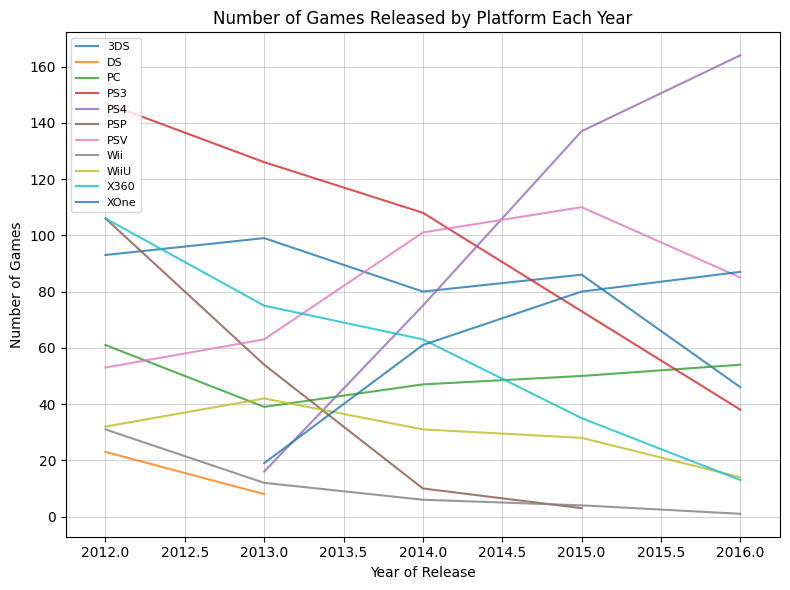

In [37]:
# Group the data by platform and year, and count the number of games
num_games_by_year = games_2012_2016.groupby(['platform', 'year_of_release'])['name'].nunique().reset_index()

# Pivot the table to have years as columns and platforms as rows
num_games_pivot = num_games_by_year.pivot(index='platform', columns='year_of_release', values='name')

# Plot the distribution
fig3, ax = plt.subplots(figsize=(8, 6))

for platform, games_data in num_games_pivot.iterrows():
    ax.plot(list(games_data.index), games_data.values, marker='', alpha=0.8, label=platform)

ax.set_title('Number of Games Released by Platform Each Year')
ax.set_xlabel('Year of Release')
ax.set_ylabel('Number of Games')
ax.set_xlim([2011.75, 2016.25])
ax.legend(loc='upper left', fontsize=8)
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

Looking at these two plots PS4 and XOne are the best preforming platforms financially, though all platforms seem to be shrinking. However PS4, XOne and PC all seeming to be growing in terms of games released anually. PSV, PS3 and 3DS while they're games output is lessening they may have a few years of life left, 3DS in particular is preforming the best of the three.

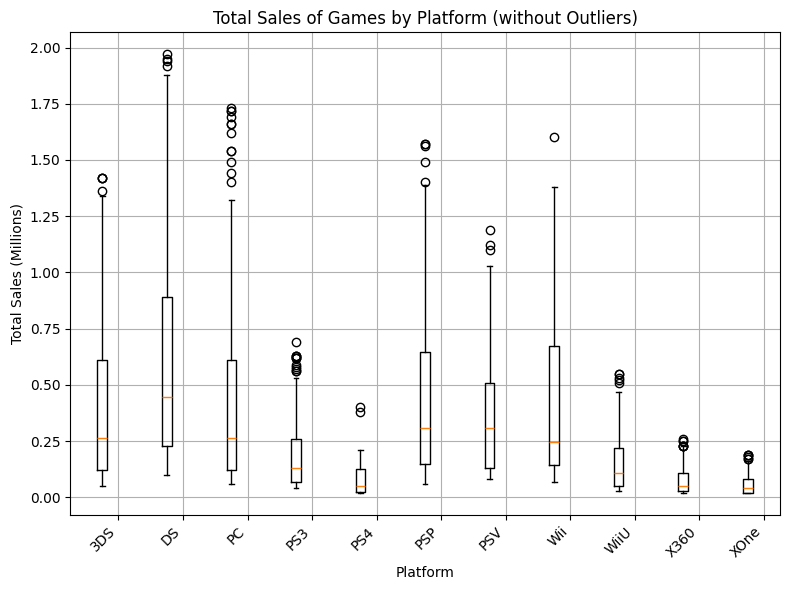

In [38]:
# Group the data by platform and calculate the total sales
platform_sales = games_2012_2016.groupby('platform')['total_sales'].sum().reset_index()

# Calculate the quartiles and the interquartile range
q1 = games_2012_2016.groupby('platform')['total_sales'].quantile(0.25)
q3 = games_2012_2016.groupby('platform')['total_sales'].quantile(0.75)
iqr = q3 - q1

# Calculate the outlier threshold
threshold = 1.5 * iqr

# Create a new figure
fig4, ax = plt.subplots(figsize=(8, 6))

# Plot the box plot for the filtered data
for i, platform in enumerate(games_2012_2016['platform'].unique()):
    filtered_data = games_2012_2016[(games_2012_2016['platform'] == platform) &
                                    (games_2012_2016['total_sales'] >= q1.loc[platform]) &
                                    (games_2012_2016['total_sales'] <= q3.loc[platform] + threshold.loc[platform])]
    bp = ax.boxplot(filtered_data['total_sales'], positions=[i - 0.25])

# Set the titles and labels
ax.set_title('Total Sales of Games by Platform (without Outliers)')
ax.set_xlabel('Platform')
ax.set_ylabel('Total Sales (Millions)')

# Move the xticks to the right
ax.set_xticks(range(len(platform_sales)))
ax.set_xticklabels(platform_sales['platform'], ha='right', rotation=45)
ax.grid(True)

plt.tight_layout()
plt.show()

The newer platforms (PS4 and XOne) have a considerably lower average than most other platforms. DS has the best average and overall sales but it is no longer making games. It looks like the majority of games released make less than 0.5 million in profit. There are number of platforms that reach higher with outliers getting close to 2 million.

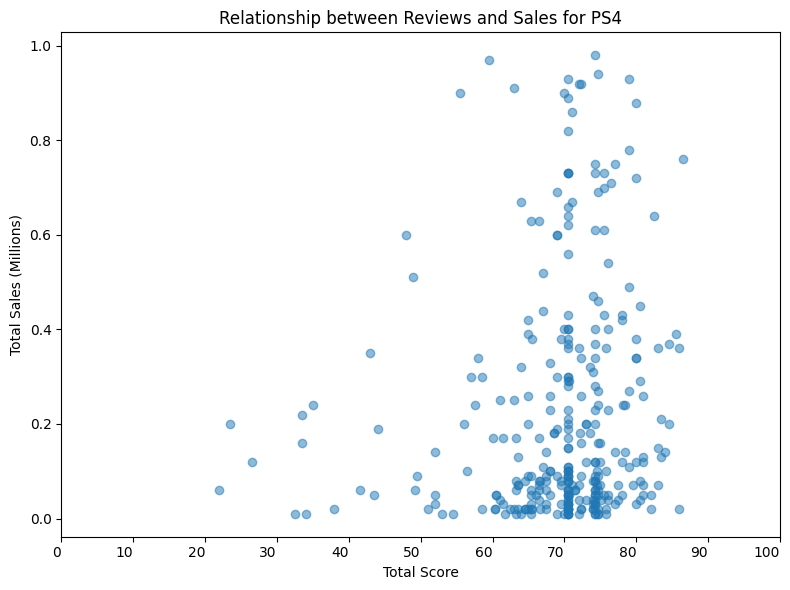

In [39]:
# Create a new column called total_score
games_2012_2016 = games_2012_2016.assign(total_score=((games_2012_2016['user_score']*10) + games_2012_2016['critic_score'])/2)

# Calculate the quartiles and the interquartile range
q1 = games_2012_2016['total_sales'].quantile(0.25)
q3 = games_2012_2016['total_sales'].quantile(0.75)
iqr = q3 - q1

# Calculate the lower and upper bounds for the outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter the data to remove the outliers
filtered_data = games_2012_2016[(games_2012_2016['total_sales'] >= lower_bound) & (games_2012_2016['total_sales'] <= upper_bound)]

# Filter the data for the DS platform
ps4_games = filtered_data[filtered_data['platform'] == 'PS4']

# Create a new figure
fig5, ax = plt.subplots(figsize=(8, 6))

# Plot the scatter plot
ax.scatter(ps4_games['total_score'], ps4_games['total_sales'], alpha=0.5)

# Set the titles and labels
ax.set_title('Relationship between Reviews and Sales for PS4')
ax.set_xlabel('Total Score')
ax.set_ylabel('Total Sales (Millions)')

# Move the xticks to the right
ax.set_xticks(range(0, 101, 10))
ax.set_xticklabels(range(0, 101, 10), ha='right')

plt.tight_layout()
plt.show()

In [40]:
# Calculate the correlation
corr = ps4_games[['critic_score', 'user_score', 'total_score', 'total_sales']].corr()

print(corr)

              critic_score  user_score  total_score  total_sales
critic_score      1.000000    0.611241     0.868793     0.229064
user_score        0.611241    1.000000     0.922946     0.026182
total_score       0.868793    0.922946     1.000000     0.127789
total_sales       0.229064    0.026182     0.127789     1.000000


The correlation matrix shows that the total_score and total_sales columns have a correlation coefficient of 0.128, indicating a weak positive linear relationship. This suggests people will buy a game regardless of the score.

In [41]:
# Find the rows that are duplicated
duplicated_rows = games_2012_2016.duplicated(subset='name', keep=False)

# Select the rows that are duplicated
duplicated_games = games_2012_2016[duplicated_rows]

# Alphabetize the DataFrame by the name column
duplicated_games = duplicated_games.sort_values(by='name')

# Print the number of duplicated games
print(len(duplicated_games))

# Print the first few rows of the duplicated games
print(duplicated_games.head(20))

1814
                                                   name platform  \
632                                Frozen: Olaf's Quest       DS   
567                                Frozen: Olaf's Quest      3DS   
554                          2014 FIFA World Cup Brazil      PS3   
722                          2014 FIFA World Cup Brazil     X360   
1073                  3rd Super Robot Wars Z Jigoku Hen      PS3   
1194                  3rd Super Robot Wars Z Jigoku Hen      PSV   
1322                3rd Super Robot Wars Z: Tengoku-Hen      PS3   
1191                3rd Super Robot Wars Z: Tengoku-Hen      PSV   
1375                                      7 Days to Die      PS4   
1960                                      7 Days to Die     XOne   
1720                            AKB1/149: Love Election      PS3   
1062                            AKB1/149: Love Election      PSP   
1765                            AKB1/149: Love Election      PSV   
2700                        Abunai: Koi no 

In [42]:
# Create a pivot table of the total sales by name and platform
pivot_table = duplicated_games.pivot_table(values='total_sales', index='name', columns='platform', aggfunc=sum)

pivot_table

C:\Users\Darth Piggyus\AppData\Local\Temp\ipykernel_2944\3810097396.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_table = duplicated_games.pivot_table(values='total_sales', index='name', columns='platform', aggfunc=sum)


platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
name,,,,,,,,,,,
Frozen: Olaf's Quest,0.59,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014 FIFA World Cup Brazil,NaN,NaN,NaN,0.61,NaN,NaN,NaN,NaN,NaN,0.43,NaN
3rd Super Robot Wars Z Jigoku Hen,NaN,NaN,NaN,0.23,NaN,NaN,0.19,NaN,NaN,NaN,NaN
3rd Super Robot Wars Z: Tengoku-Hen,NaN,NaN,NaN,0.15,NaN,NaN,0.19,NaN,NaN,NaN,NaN
7 Days to Die,NaN,NaN,NaN,NaN,0.14,NaN,NaN,NaN,NaN,NaN,0.05
...,...,...,...,...,...,...,...,...,...,...,...
Zone of the Enders HD Collection,NaN,NaN,NaN,0.42,NaN,NaN,NaN,NaN,NaN,0.20,NaN
Zoo Tycoon (2013),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09,0.36
Zumba Fitness Core,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,NaN,0.05,NaN


PS4 is the most financially successful platform in recent history so i will filter for rows that have sales with it.

In [43]:
# Find the rows that have non-null values in the PS4 column
ps4_games = pivot_table.loc[:, 'PS4'].notna()

# Create a new DataFrame from the selected rows
selected_games = pivot_table[ps4_games]

# Print the new DataFrame
selected_games

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
name,,,,,,,,,,,
7 Days to Die,NaN,NaN,NaN,NaN,0.14,NaN,NaN,NaN,NaN,NaN,0.05
Adventure Time: Finn & Jake Investigations,0.09,NaN,NaN,0.08,0.10,NaN,NaN,NaN,0.05,0.09,0.05
Aegis of Earth: Protonovus Assault,NaN,NaN,NaN,0.02,0.02,NaN,0.03,NaN,NaN,NaN,NaN
Agatha Christie's The ABC Murders,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,0.01
Akiba's Trip: Undead & Undressed,NaN,NaN,NaN,0.11,0.11,NaN,0.15,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Yakuza Zero: The Place of Oath,NaN,NaN,NaN,0.25,0.17,NaN,NaN,NaN,NaN,NaN,NaN
Yakuza: Ishin,NaN,NaN,NaN,0.26,0.15,NaN,NaN,NaN,NaN,NaN,NaN
Yoru no Nai Kuni,NaN,NaN,NaN,0.05,0.08,NaN,0.08,NaN,NaN,NaN,NaN


In [44]:
# Create a dropdown menu to select a game
game_dropdown = Dropdown(options=selected_games.index, description='Select a game:')

# Function to update the plot based on the selected game
def update_plot(game):
    # Filter the DataFrame based on the selected game
    filtered_game = selected_games.loc[game].dropna()
    
    # Plotting the sales of the selected game on different platforms
    filtered_game.plot(kind='bar', figsize=(10, 6))
    
    # Adding labels and title to the plot
    plt.title(f'Sales of {game} on Different Platforms')
    plt.xlabel('Platforms')
    plt.ylabel('Sales')
    
    # Rotating the x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Displaying the plot
    plt.show()

# Interact function to update the plot based on the dropdown selection
interact(update_plot, game=game_dropdown)


interactive(children=(Dropdown(description='Select a game:', options=('7 Days to Die', 'Adventure Time: Finn &…

<function __main__.update_plot(game)>

In [45]:
# Calculate the total sales for each game
selected_games['Total_Sales'] = selected_games.sum(axis=1, skipna=True)

# Calculate the percentage of total sales that the PS4 sales represent for each game
selected_games['PS4_Sales_Percentage'] = round((selected_games['PS4'] / selected_games['Total_Sales']) * 100, 2)

# Display the updated DataFrame
selected_games

C:\Users\Darth Piggyus\AppData\Local\Temp\ipykernel_2944\2148294324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_games['Total_Sales'] = selected_games.sum(axis=1, skipna=True)
C:\Users\Darth Piggyus\AppData\Local\Temp\ipykernel_2944\2148294324.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_games['PS4_Sales_Percentage'] = round((selected_games['PS4'] / selected_games['Total_Sales']) * 100, 2)


platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne,Total_Sales,PS4_Sales_Percentage
name,,,,,,,,,,,,,
7 Days to Die,NaN,NaN,NaN,NaN,0.14,NaN,NaN,NaN,NaN,NaN,0.05,0.19,73.68
Adventure Time: Finn & Jake Investigations,0.09,NaN,NaN,0.08,0.10,NaN,NaN,NaN,0.05,0.09,0.05,0.46,21.74
Aegis of Earth: Protonovus Assault,NaN,NaN,NaN,0.02,0.02,NaN,0.03,NaN,NaN,NaN,NaN,0.07,28.57
Agatha Christie's The ABC Murders,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,0.01,0.03,66.67
Akiba's Trip: Undead & Undressed,NaN,NaN,NaN,0.11,0.11,NaN,0.15,NaN,NaN,NaN,NaN,0.37,29.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yakuza Zero: The Place of Oath,NaN,NaN,NaN,0.25,0.17,NaN,NaN,NaN,NaN,NaN,NaN,0.42,40.48
Yakuza: Ishin,NaN,NaN,NaN,0.26,0.15,NaN,NaN,NaN,NaN,NaN,NaN,0.41,36.59
Yoru no Nai Kuni,NaN,NaN,NaN,0.05,0.08,NaN,0.08,NaN,NaN,NaN,NaN,0.21,38.10


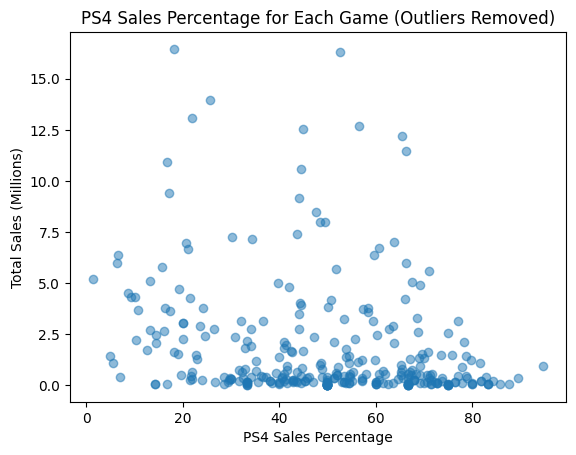

In [46]:
# Calculate the z-scores for 'Total_Sales' and 'PS4_Sales_Percentage'
total_sales_zscore = np.abs((selected_games['Total_Sales'] - selected_games['Total_Sales'].mean()) / selected_games['Total_Sales'].std())
percentage_zscore = np.abs((selected_games['PS4_Sales_Percentage'] - selected_games['PS4_Sales_Percentage'].mean()) / selected_games['PS4_Sales_Percentage'].std())

# Filter out the outliers using the three sigma rule
filtered_games = selected_games[(total_sales_zscore < 3) & (percentage_zscore < 3)]

# Plotting the PS4 sales percentage for each game after removing outliers
plt.scatter(filtered_games['PS4_Sales_Percentage'], filtered_games['Total_Sales'], alpha=0.5)
plt.xlabel('PS4 Sales Percentage')
plt.ylabel('Total Sales (Millions)')
plt.title('PS4 Sales Percentage for Each Game (Outliers Removed)')
plt.show()

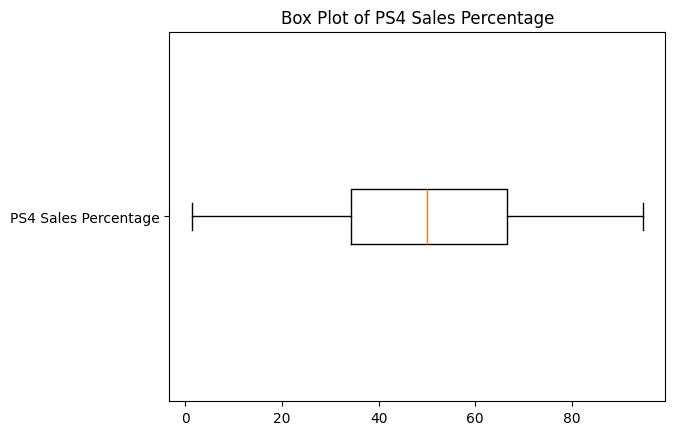

In [47]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the box plot for PS4 Sales Percentage
ax.boxplot(selected_games['PS4_Sales_Percentage'], vert=False)

# Add a label to the y-axis
ax.set_yticklabels(['PS4 Sales Percentage'])

# Set the title of the plot
ax.set_title('Box Plot of PS4 Sales Percentage')

# Display the plot
plt.show()

Looking over this data we can see that the majority of these titles have 40% to 70% of their sales on the PS4 with the average being 50% of total sales. This suggests that it's the strongest console moving forward.

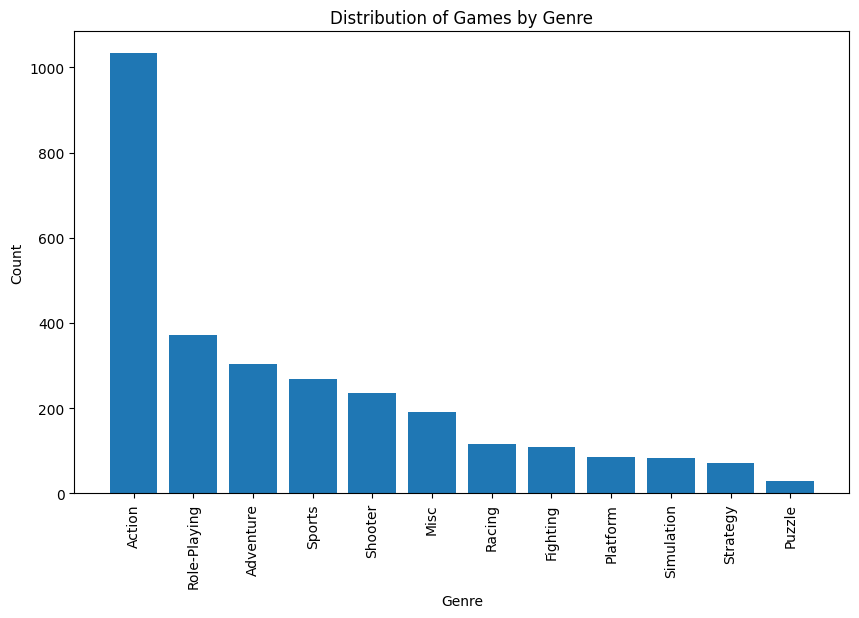

Genres with the highest sales:
genre
Action          441.87
Shooter         304.80
Role-Playing    193.09
Sports          181.09
Misc             85.04
Name: total_sales, dtype: float64

Genres with the lowest sales:
genre
Fighting      44.49
Simulation    35.61
Adventure     29.52
Strategy      13.34
Puzzle         4.89
Name: total_sales, dtype: float64

Average sales per genre:


genre
Shooter         1.29
Platform        0.72
Sports          0.67
Role-Playing    0.52
Racing          0.46
Misc            0.44
Action          0.43
Simulation      0.43
Fighting        0.41
Strategy        0.19
Puzzle          0.17
Adventure       0.10
Name: total_sales, dtype: float64

In [48]:
# Calculate the count of games in each genre
genre_counts = games_2012_2016['genre'].value_counts()

# Create a bar plot for the genre distribution
plt.figure(figsize=(10, 6))
plt.bar(genre_counts.index, genre_counts.values)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Distribution of Games by Genre')
plt.xticks(rotation=90)
plt.show()

# Calculate the total sales for each genre
genre_sales = games_2012_2016.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

# Print the genres with the highest sales
print("Genres with the highest sales:")
print(genre_sales.head())

# Print the genres with the lowest sales
print("\nGenres with the lowest sales:")
print(genre_sales.tail())

# Calculate the average sales per genre
average_sales_per_genre = games_2012_2016.groupby('genre')['total_sales'].mean().round(2).sort_values(ascending=False)

# Display the average sales per genre
print("\nAverage sales per genre:")
average_sales_per_genre

The most profitable genres are the most prolific ones with the exception of adventure which actually has one of the lowest revenues and the worst preforming genres follow that trend with fewer releases. The action market is completely over saturated, bringing down the average sales for games released in that genre. The shooter genre has far fewer releases but the second highest total sales so it looks like the best genre to go for.

In [49]:
# Filter games with non-zero na_sales
na_games = games_2012_2016[games_2012_2016['na_sales'] > 0].copy()
na_games['region'] = 'na'

# Filter games with non-zero eu_sales
eu_games = games_2012_2016[games_2012_2016['eu_sales'] > 0].copy()
eu_games['region'] = 'eu'

# Filter games with non-zero jp_sales
jp_games = games_2012_2016[games_2012_2016['jp_sales'] > 0].copy()
jp_games['region'] = 'jp'

In [50]:
# Function to get top 5 platforms and their market shares
def get_top_platforms(df):
    top_platforms = df.groupby('platform')['total_sales'].sum().nlargest(5)
    market_shares = ((top_platforms / df['total_sales'].sum()) * 100).round(2)
    return top_platforms, market_shares

# Function to get top 5 genres
def get_top_genres(df):
    top_genres = df['genre'].value_counts().nlargest(5)
    return top_genres

# Function to analyze ESRB ratings and sales in each region
def analyze_esrb_ratings(df):
    ratings_sales = df.groupby('rating')['total_sales'].sum()
    return ratings_sales

In [51]:
# Analyze NA region
print("User Profile for North America (NA):")
na_top_platforms, na_market_shares = get_top_platforms(na_games)
print("Top Platforms:")
print(na_top_platforms)
print("Market Shares:")
print(na_market_shares)

na_top_genres = get_top_genres(na_games)
print("Top Genres:")
print(na_top_genres)

na_esrb_sales = analyze_esrb_ratings(na_games)
print("ESRB Ratings Sales:")
na_esrb_sales

User Profile for North America (NA):
Top Platforms:
platform
PS4     307.48
PS3     274.62
X360    235.90
XOne    159.00
3DS     158.48
Name: total_sales, dtype: float64
Market Shares:
platform
PS4     22.82
PS3     20.38
X360    17.51
XOne    11.80
3DS     11.76
Name: total_sales, dtype: float64
Top Genres:
genre
Action          591
Shooter         213
Role-Playing    196
Sports          182
Misc            104
Name: count, dtype: int64
ESRB Ratings Sales:


rating
E       313.42
E10+    161.36
M       685.58
T       187.14
Name: total_sales, dtype: float64

In [60]:
# Analyze EU region
print("User Profile for Europe (EU):")
eu_top_platforms, eu_market_shares = get_top_platforms(eu_games)
print("Top Platforms:")
print(eu_top_platforms)
print("Market Shares:")
print(eu_market_shares)

eu_top_genres = get_top_genres(eu_games)
print("Top Genres:")
print(eu_top_genres)

eu_esrb_sales = analyze_esrb_ratings(eu_games)
print("ESRB Ratings Sales:")
eu_esrb_sales

User Profile for Europe (EU):
Top Platforms:
platform
PS4     306.41
PS3     268.49
X360    231.75
XOne    158.66
3DS     154.88
Name: total_sales, dtype: float64
Market Shares:
platform
PS4     22.83
PS3     20.01
X360    17.27
XOne    11.82
3DS     11.54
Name: total_sales, dtype: float64
Top Genres:
genre
Action          644
Shooter         215
Sports          202
Role-Playing    197
Misc            104
Name: count, dtype: int64
ESRB Ratings Sales:


rating
E       312.33
E10+    160.08
M       684.15
T       185.51
Name: total_sales, dtype: float64

In [59]:
# Analyze JP region
print("User Profile for Japan (JP):")
jp_top_platforms, jp_market_shares = get_top_platforms(jp_games)
print("Top Platforms:")
print(jp_top_platforms)
print("Market Shares:")
print(jp_market_shares)

jp_top_genres = get_top_genres(jp_games)
print("Top Genres:")
print(jp_top_genres)

jp_esrb_sales = analyze_esrb_ratings(jp_games)
print("ESRB Ratings Sales:")
jp_esrb_sales


User Profile for Japan (JP):
Top Platforms:
platform
PS4     264.86
PS3     228.08
3DS     182.52
X360    135.10
WiiU     66.12
Name: total_sales, dtype: float64
Market Shares:
platform
PS4     26.71
PS3     23.00
3DS     18.41
X360    13.63
WiiU     6.67
Name: total_sales, dtype: float64
Top Genres:
genre
Action          563
Role-Playing    301
Adventure       206
Misc            108
Shooter          93
Name: count, dtype: int64
ESRB Ratings Sales:


rating
E       213.49
E10+     97.12
M       491.23
T       189.61
Name: total_sales, dtype: float64

In [54]:
# Combine the market share dataframes into one dataframe
market_share_data = pd.concat([na_market_shares, jp_market_shares, eu_market_shares], axis=1, sort=False)
market_share_data.columns = ['North America', 'Japan', 'Europe']

# Fill missing values with 0
market_share_data = market_share_data.fillna(0)

# Create a dropdown menu for platform selection
platform_dropdown = widgets.Dropdown(
    options=market_share_data.index,
    description='Platform:',
    value=market_share_data.index[0],
    disabled=False
)

# Create a function to update the graph based on the selected platform
def update_graph(platform):
    plt.figure(figsize=(8, 6))

    # Get the market share data for the selected platform
    data = market_share_data.loc[platform]

    # Create the bar plot
    plt.bar(data.index, data.values)
    plt.xlabel('Region')
    plt.ylabel('Market Share (%)')
    plt.title(f'Market Share by Region for {platform}')

    # Display the plot
    plt.show()

# Call the update_graph function when the dropdown value changes
widgets.interactive(update_graph, platform=platform_dropdown)

interactive(children=(Dropdown(description='Platform:', options=('PS4', 'PS3', 'X360', 'XOne', '3DS', 'WiiU'),…

Looking at these graphs its easy to see that Playstation is dominating with 40% or greater of the market share with the PS3 and PS4. Xbox is close with ~30% of the market share in NA and EU markets but hardly shows up for JP. Nintendo Makes up a minor share of the JP market with the WiiU but makes a bit a of showing with the 3DS making up more than 10% in each of it's markets.

In [55]:
# Group the dataframes by genre and calculate the sum of total sales for each genre
na_genre_sales = na_games.groupby('genre')['total_sales'].sum()
jp_genre_sales = jp_games.groupby('genre')['total_sales'].sum()
eu_genre_sales = eu_games.groupby('genre')['total_sales'].sum()

# Find the top genres for each region based on the highest total sales
top_na_genres = na_genre_sales.nlargest(5)
top_jp_genres = jp_genre_sales.nlargest(5)
top_eu_genres = eu_genre_sales.nlargest(5)

# Print the top genres for each region
print("Top genres in North America:")
print(top_na_genres)
print("\nTop genres in Japan:")
print(top_jp_genres)
print("\nTop genres in Europe:")
print(top_eu_genres)

Top genres in North America:
genre
Action          407.87
Shooter         303.38
Sports          171.71
Role-Playing    166.98
Misc             77.72
Name: total_sales, dtype: float64

Top genres in Japan:
genre
Action          298.39
Shooter         234.66
Role-Playing    164.29
Sports           82.52
Platform         46.02
Name: total_sales, dtype: float64

Top genres in Europe:
genre
Action          405.45
Shooter         303.95
Sports          168.51
Role-Playing    162.52
Misc             78.43
Name: total_sales, dtype: float64


C:\Users\Darth Piggyus\AppData\Local\Temp\ipykernel_2944\2791092995.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\Darth Piggyus\AppData\Local\Temp\ipykernel_2944\2791092995.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\Darth Piggyus\AppData\Local\Temp\ipykernel_2944\2791092995.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


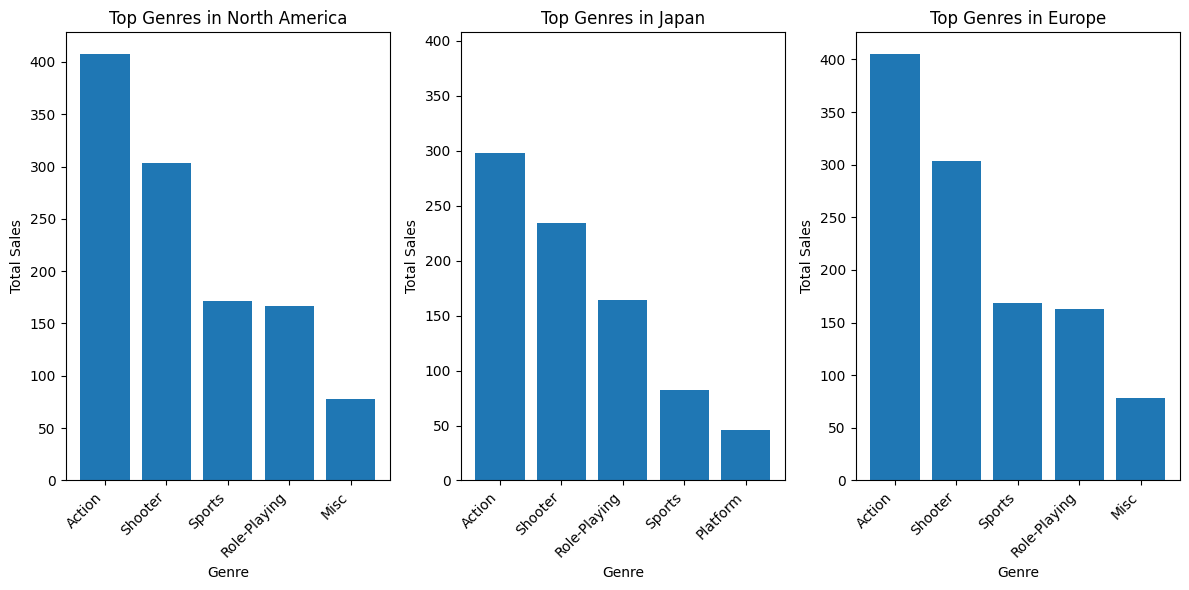

In [58]:
# Create bar plots for the top genres in each region
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
plt.subplots_adjust(wspace=0.4)

# Plot for North America
axes[0].bar(top_na_genres.index, top_na_genres.values)
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Total Sales')
axes[0].set_title('Top Genres in North America')

# Plot for Japan
axes[1].bar(top_jp_genres.index, top_jp_genres.values)
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Total Sales')
axes[1].set_title('Top Genres in Japan')
axes[1].set_ylim(0, top_na_genres.max())  # Set the y-axis limits to match the other two plots

# Plot for Europe
axes[2].bar(top_eu_genres.index, top_eu_genres.values)
axes[2].set_xlabel('Genre')
axes[2].set_ylabel('Total Sales')
axes[2].set_title('Top Genres in Europe')

# Rotate x-axis labels for all plots
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Display the plots
plt.tight_layout()
plt.show()

Action and Shooter hold the top spots in all regions, though it is notable that the Japanese market spends less money on these titles than other regions. NA and EU markets are nearly identical to each other, where Japan seems to value Role-Playing over Sports and Platformers over Misc titles.

In [72]:
# Convert the Series to DataFrames if needed
if isinstance(jp_esrb_sales, pd.Series):
    jp_esrb_sales = jp_esrb_sales.to_frame()
if isinstance(na_esrb_sales, pd.Series):
    na_esrb_sales = na_esrb_sales.to_frame()
if isinstance(eu_esrb_sales, pd.Series):
    eu_esrb_sales = eu_esrb_sales.to_frame()

# Add a new 'region' column to each dataframe
jp_esrb_sales['region'] = 'JP'
na_esrb_sales['region'] = 'NA'
eu_esrb_sales['region'] = 'EU'

# Concatenate the dataframes vertically
combined_df = pd.concat([jp_esrb_sales, na_esrb_sales, eu_esrb_sales])

# Reset the index of the combined dataframe
combined_df.reset_index(inplace=True)

# Reshape the dataframe using the pd.melt() function
melted_df = pd.melt(combined_df, id_vars=['rating', 'region'], var_name='total_sales', value_name='sales')

# Pivot the dataframe to have regions as rows and ratings as columns
pivot_df = melted_df.pivot(index='rating', columns='region', values='sales')

# Display the final dataframe
print(pivot_df)

region      EU      JP      NA
rating                        
E       312.33  213.49  313.42
E10+    160.08   97.12  161.36
M       684.15  491.23  685.58
T       185.51  189.61  187.14


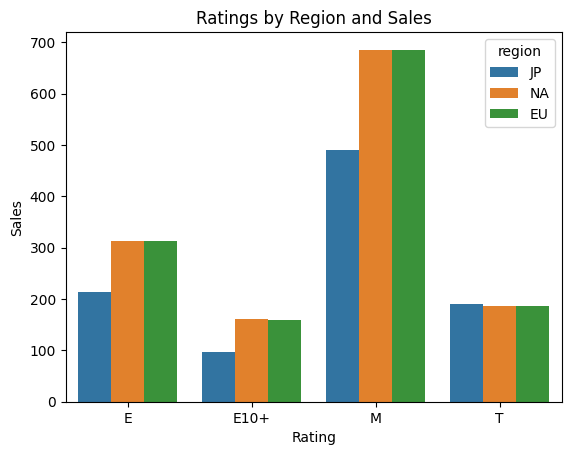

In [74]:
# Create the bar plot using Seaborn
sns.barplot(data=melted_df, x='rating', y='sales', hue='region')

# Set the labels and title
plt.xlabel('Rating')
plt.ylabel('Sales')
plt.title('Ratings by Region and Sales')

# Display the bar plot
plt.show()

The spenmding trends seem to be the same between regions in that M rated games are the top sellers doubling the next closest rating category. 

To test the hypotheses, I'll| use a two-sample t-test for the first hypothesis and a two-sample t-test for independent samples for the second hypothesis.

Hypothesis 1: "Average user ratings of the Xbox One and PC platforms are the same"
Null Hypothesis (H0): The average user ratings of the Xbox One and PC platforms are the same.
Alternative Hypothesis (H1): The average user ratings of the Xbox One and PC platforms are different.

alpha = 0.05 (5%)

In [80]:
# Filter the dataframe for Xbox games and extract the 'user_score' column
xbox_scores = games_2012_2016[games_2012_2016['platform'] == 'XOne']['user_score']

# Filter the dataframe for PC games and extract the 'user_score' column
pc_scores = games_2012_2016[games_2012_2016['platform'] == 'PC']['user_score']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_ind(xbox_scores, pc_scores)

# Set the significance level (alpha)
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("The average user ratings of the Xbox One and PC platforms are different.")
else:
    print("Fail to reject the null hypothesis.")
    print("The average user ratings of the Xbox One and PC platforms are the same.")

Fail to reject the null hypothesis.
The average user ratings of the Xbox One and PC platforms are the same.


The null hypothesis assumes that there is no difference in the average user ratings between the Xbox One and PC platforms. The alternative suggests that there is a significant difference in the average user ratings between the Xbox One and PC platforms. As we can see Xbox One and PC have a very similar average user rating.

I chose 0.05 as my signifigance level because it's the most commonly used in hypothesis testing.


Hypothesis 2: "Average user ratings for the Action and Sports genres are different."
Null Hypothesis (H0): The average user ratings for the Action and Sports genres are the same.
Alternative Hypothesis (H1): The average user ratings for the Action and Sports genres are different.

alpha = 0.05 (5%)

In [79]:
# Filter the dataframe for Action games and extract the 'user_score' column
action_score = games_2012_2016[games_2012_2016['genre'] == 'Action']['user_score']

# Filter the dataframe for Sports games and extract the 'user_score' column
sports_score = games_2012_2016[games_2012_2016['genre'] == 'Sports']['user_score']

# Perform the two-sample t-test
t_stat, p_value = stats.ttest_ind(action_score, sports_score)

print("T-statistic:", t_stat)
print("P-value:", p_value)

# Compare the p-value with the significance level
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference in the average user ratings.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in the average user ratings.")

T-statistic: 11.153987094957493
P-value: 1.1775818982861812e-27
Reject the null hypothesis. There is a significant difference in the average user ratings.


The null hypothesis assumes that there is no difference in the average user ratings between the Action and Sports genres. The alternative hypothesis suggests that there is a significant difference in the average user ratings between the Action and Sports genres. As we can see Action and Sports game's user score have very little correlation with each other.

I chose 0.05 as my signifigance level because it's the most commonly used in hypothesis testing.

### Conclusion ###

Based on the analysis of the data, Sony emerges as the dominant player in the gaming market for 2017, particularly with their PS3 and PS4 consoles. However, it is recommended to focus more on the PS4, as the sales of PS3 are declining and its lifespan is nearing its end. Xbox One is also a viable investment option, especially for markets outside of Japan, given its strong presence in North America and Europe.

In terms of game genres, shooters prove to be the most lucrative, followed by action games that sell a substantial number of copies. Sports and platformer games generate less revenue, particularly in the Japanese market, but they still hold significance and warrant attention. Both the North American and European markets exhibit similar spending patterns, with a preference for action and shooter games.

Furthermore, it is noteworthy that M-rated games, which target mature audiences, are the most popular and profitable across all regions.

Overall, the conclusion highlights the market dominance of Sony, the potential of Xbox One, the profitability of shooter and action games, and the significance of M-rated titles in driving sales and revenue.

